In [1]:
%reload_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
%matplotlib inline

In [2]:
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube_sh.sentinelhub import SentinelHub
import xarray as xr
import numpy as np
import os
import json
import shapely.geometry
import IPython.display
from src.GIS_utils import bbox_from_point

In [3]:
SH = SentinelHub()
print(SH.dataset_names)

None


In [4]:
SH.band_names('S1GRD')

['VV', 'VH', 'HH', 'HV']

In [7]:
data_dir = "/home/jovyan/data" # data directory (path)
RADIUS = 500 # AOI radius in meters

spatial_res = 0.00018
start_date = '2019-03-01'
end_date = '2019-06-01'

with open(os.path.join(data_dir, 'aoi.json'), 'r') as f:
    aoi_file = json.load(f)
    coord = aoi_file['EU_Straits']['Bosporus'][5]
    lat, lon = coord[0], coord[1]
    print('{}, {}'.format(lat, lon))

40.994, 29.017


In [8]:
bbox = bbox_from_point(lat=lat, lon=lon, r=RADIUS) # WGS84 coordinates

In [9]:
bbox = bbox_from_point(lat=lat, lon=lon, r=RADIUS) # WGS84 coordinates
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

In [52]:
cube_config = CubeConfig(dataset_name='S1GRD',
                         band_names=[ 'HH+HV', 'VV+VH', 'HH', 'VV', 'VH'], ## HH,'HV' , 'HH+HV' gives NaN/Zero Exception HH+HV, VV+VH, HH, VV
                         crs = "http://www.opengis.net/def/crs/EPSG/0/4326",
                         spatial_res = 0.00018,
                         geometry=bbox,
                         time_range=[start_date, end_date],
                         time_period='1D')

In [53]:
cube = open_cube(cube_config)
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 50, lon: 66, time: 93)
Coordinates:
  * lat        (lat) float64 41.0 41.0 41.0 41.0 ... 40.99 40.99 40.99 40.99
  * lon        (lon) float64 29.01 29.01 29.01 29.01 ... 29.02 29.02 29.02 29.02
  * time       (time) datetime64[ns] 2019-03-01T12:00:00 ... 2019-06-01T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(93, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    HH         (time, lat, lon) float32 dask.array<chunksize=(1, 50, 66), meta=np.ndarray>
    HH+HV      (time, lat, lon) float32 dask.array<chunksize=(1, 50, 66), meta=np.ndarray>
    VH         (time, lat, lon) float32 dask.array<chunksize=(1, 50, 66), meta=np.ndarray>
    VV         (time, lat, lon) float32 dask.array<chunksize=(1, 50, 66), meta=np.ndarray>
    VV+VH      (time, lat, lon) float32 dask.array<chunksize=(1, 50, 66), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     S1GRD Data Cube Subset
    history:                   [{'program': 'xcube_sh.store.SentinelHubStore'...
    date_created:              2020-06-05T10:49:13.808554
    processing_level:          L1B
    time_coverage_start:       2019-03-01T00:00:00+00:00
    time_coverage_end:         2019-06-02T00:00:00+00:00
    time_coverage_duration:    P93DT0H0M0S
    time_coverage_resolution:  P1DT0H0M0S
    geospatial_lon_min:        29.011059019742685
    geospatial_lat_min:        40.98949867050243
    geospatial_lon_max:        29.022939019742687
    geospatial_lat_max:        40.99849867050243

In [54]:
nans_how = 'any'
# cube = cube.dropna(dim='time',how=nans_how) # drop images w/ any nan. This line will crash since not all bands are presence 
cube = cube.where(cube.VV.mean(dim=('lat','lon')) > 0.0, drop=True) 

(array([3.075e+03, 1.350e+02, 5.200e+01, 1.100e+01, 1.100e+01, 6.000e+00,
        3.000e+00, 3.000e+00, 1.000e+00, 3.000e+00]),
 array([2.00000e-03, 5.61420e-01, 1.12084e+00, 1.68026e+00, 2.23968e+00,
        2.79910e+00, 3.35852e+00, 3.91794e+00, 4.47736e+00, 5.03678e+00,
        5.59620e+00], dtype=float32),
 <a list of 10 Patch objects>)

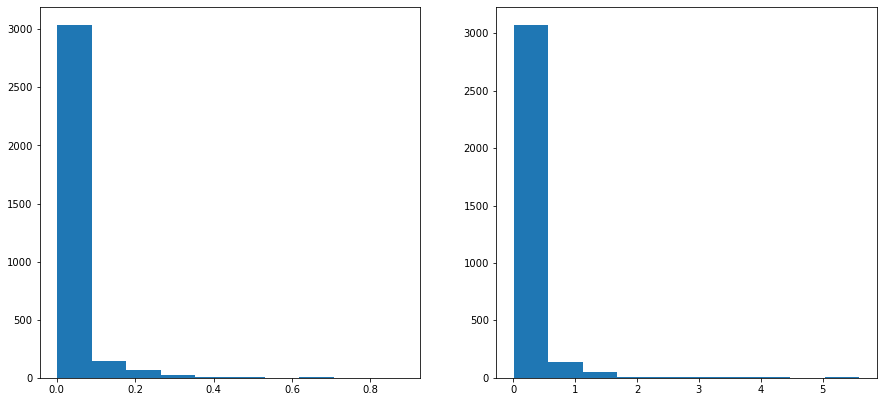

In [56]:
import matplotlib.pyplot as plt
# plt.hist()
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.hist(np.squeeze(cube.VH.isel(time=3).values.reshape(1, -1)))
plt.subplot(2, 2, 2)
plt.hist(np.squeeze(cube.VV.isel(time=3).values.reshape(1, -1)))

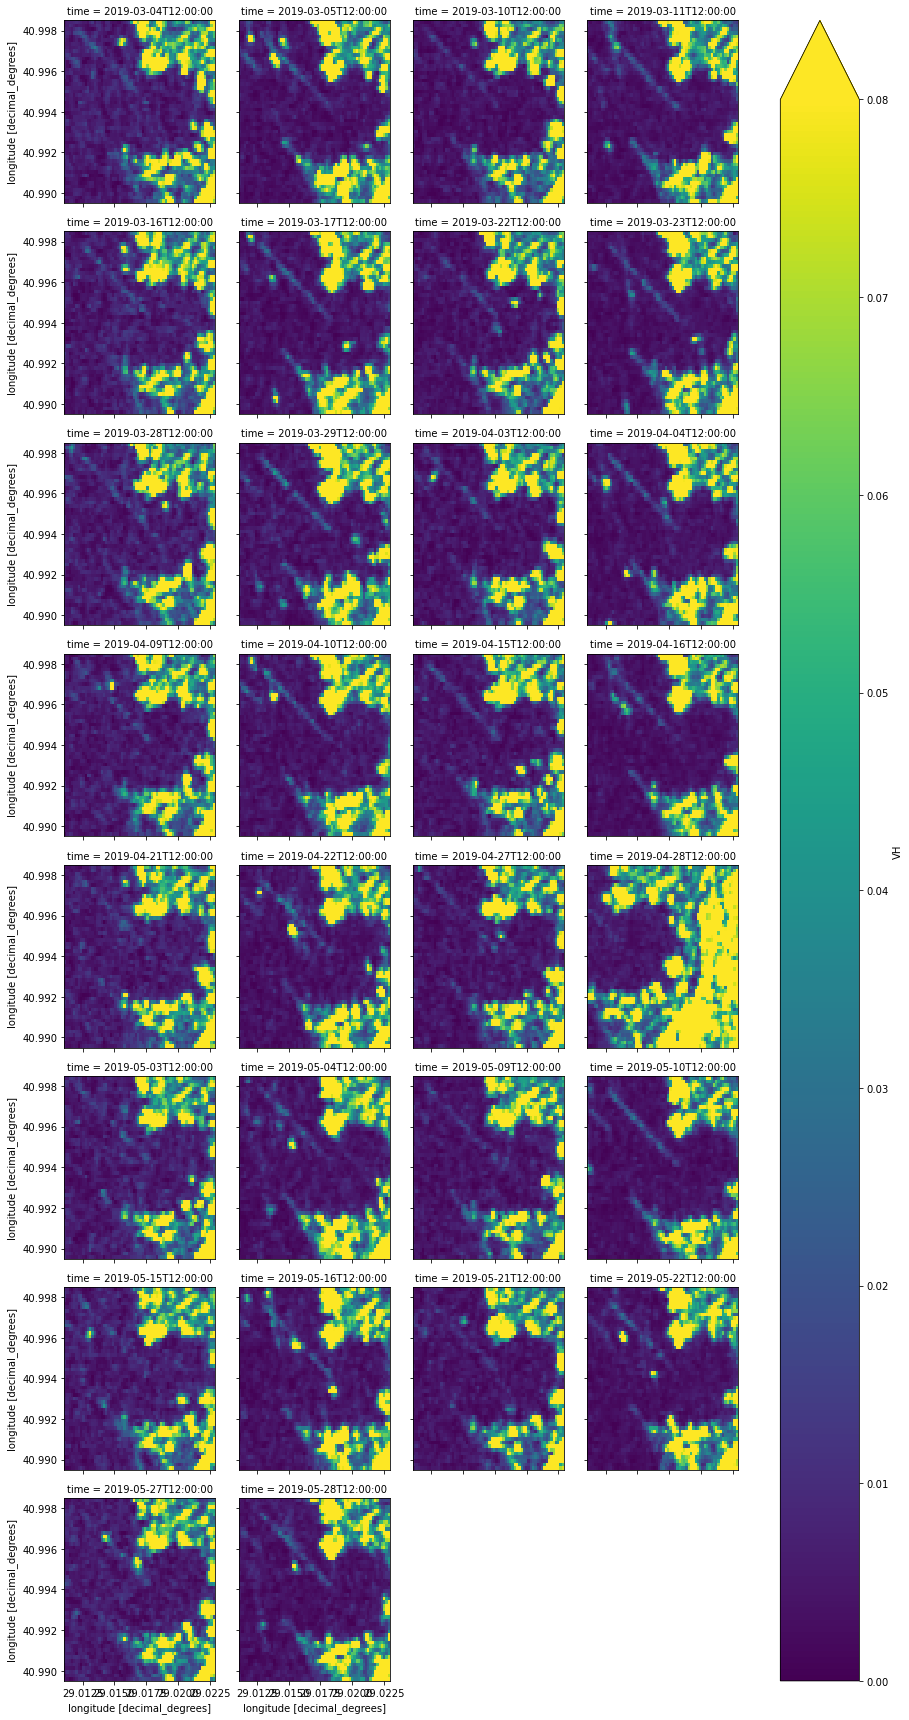

In [59]:
cube.VH.plot.imshow(col='time', col_wrap=4, vmax=0.08)

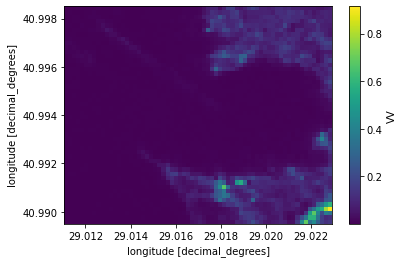

In [60]:
cube.VV.min(dim = "time").plot.imshow()

In [61]:
import xarray
def preprocess_sentinel_1(cube, band = "VH",  bg_band="VV", fused_by = "min"):
    if fused_by == "min":
        background_VH_mean = cube[bg_band].min(dim = "time")
    elif fused_by == "mean":
        background_VH_mean = cube[bg_band].mean(dim = "time")
    else:
        background_VH_mean = cube[bg_band].max(dim = "time")
    cube_before_concat = []
    for t in range(len(cube.time)):
        bg_removed = cube[band].isel(time=t) - background_VH_mean
        rescaled = (bg_removed - bg_removed.min()) / (bg_removed.max() -  bg_removed.min())
        cube_before_concat.append(rescaled)
    cube_after_concat = xarray.concat(cube_before_concat, dim= 'time')
    return cube_after_concat, background_VH_mean



In [33]:
cube_VH_bg, bg_VH = preprocess_sentinel_1(cube, band = 'VH', fused_by='min')

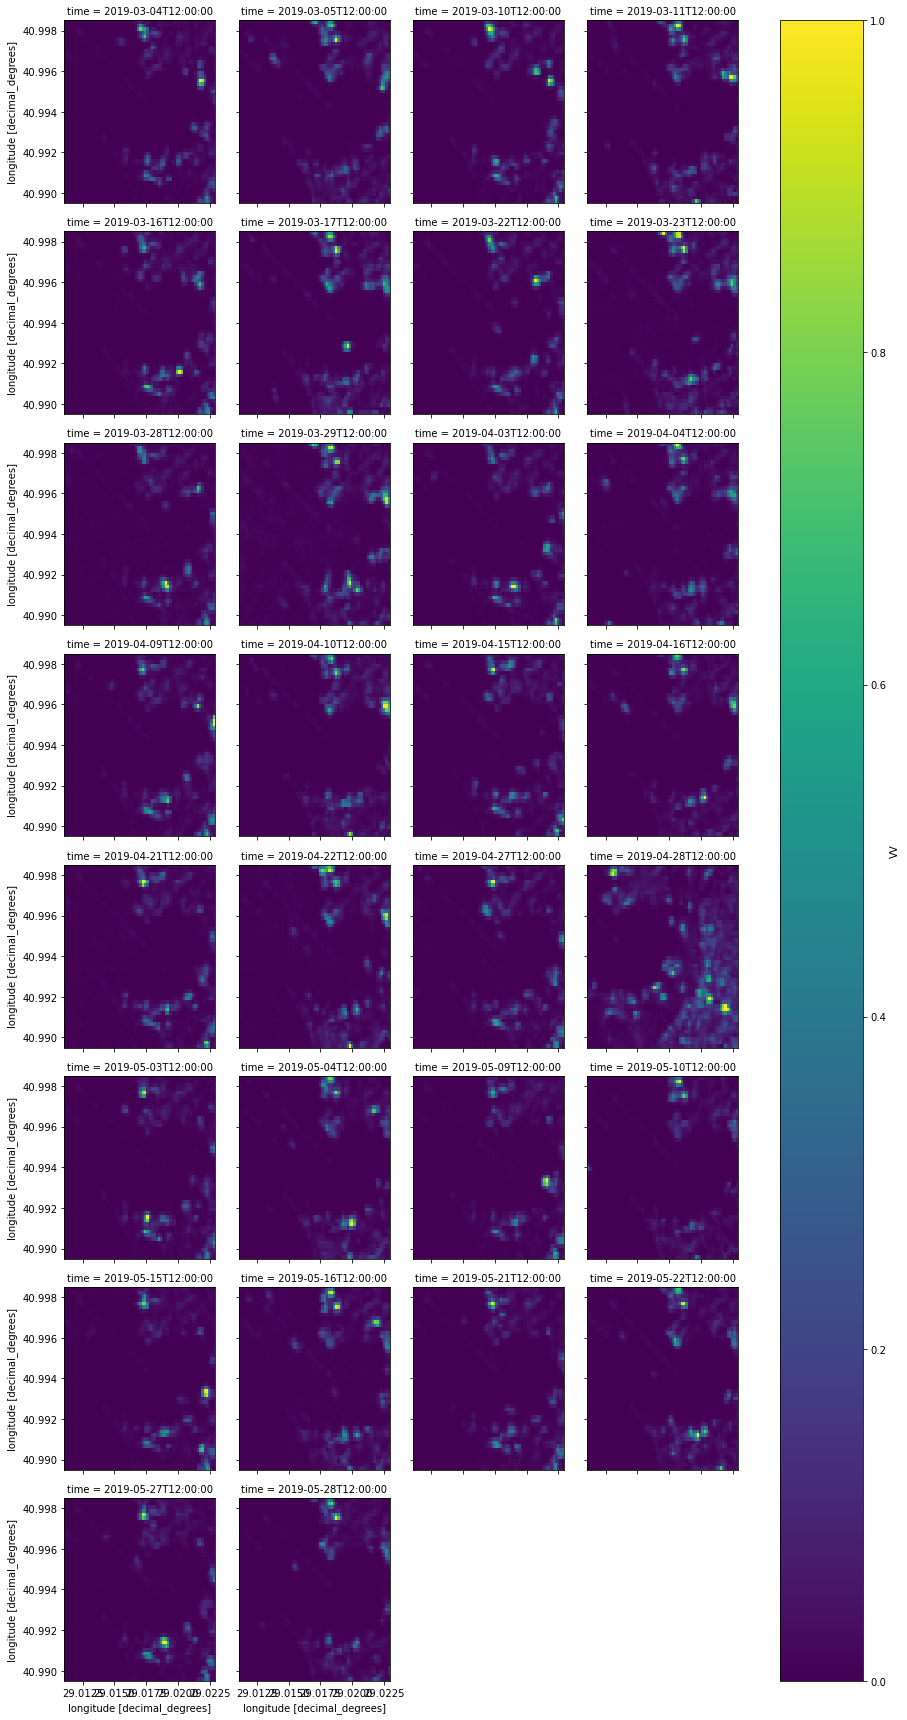

In [34]:
cube_VH_bg.plot.imshow(col='time', col_wrap=4)

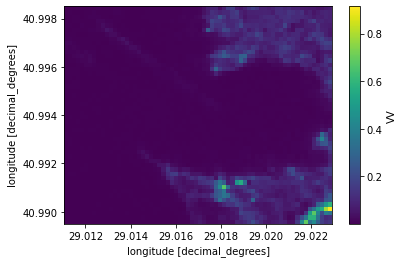

In [35]:
bg_VH.plot.imshow()

### Method here https://github.com/sentinel-hub/custom-scripts/tree/master/sentinel-1/water_surface_roughness_visualization

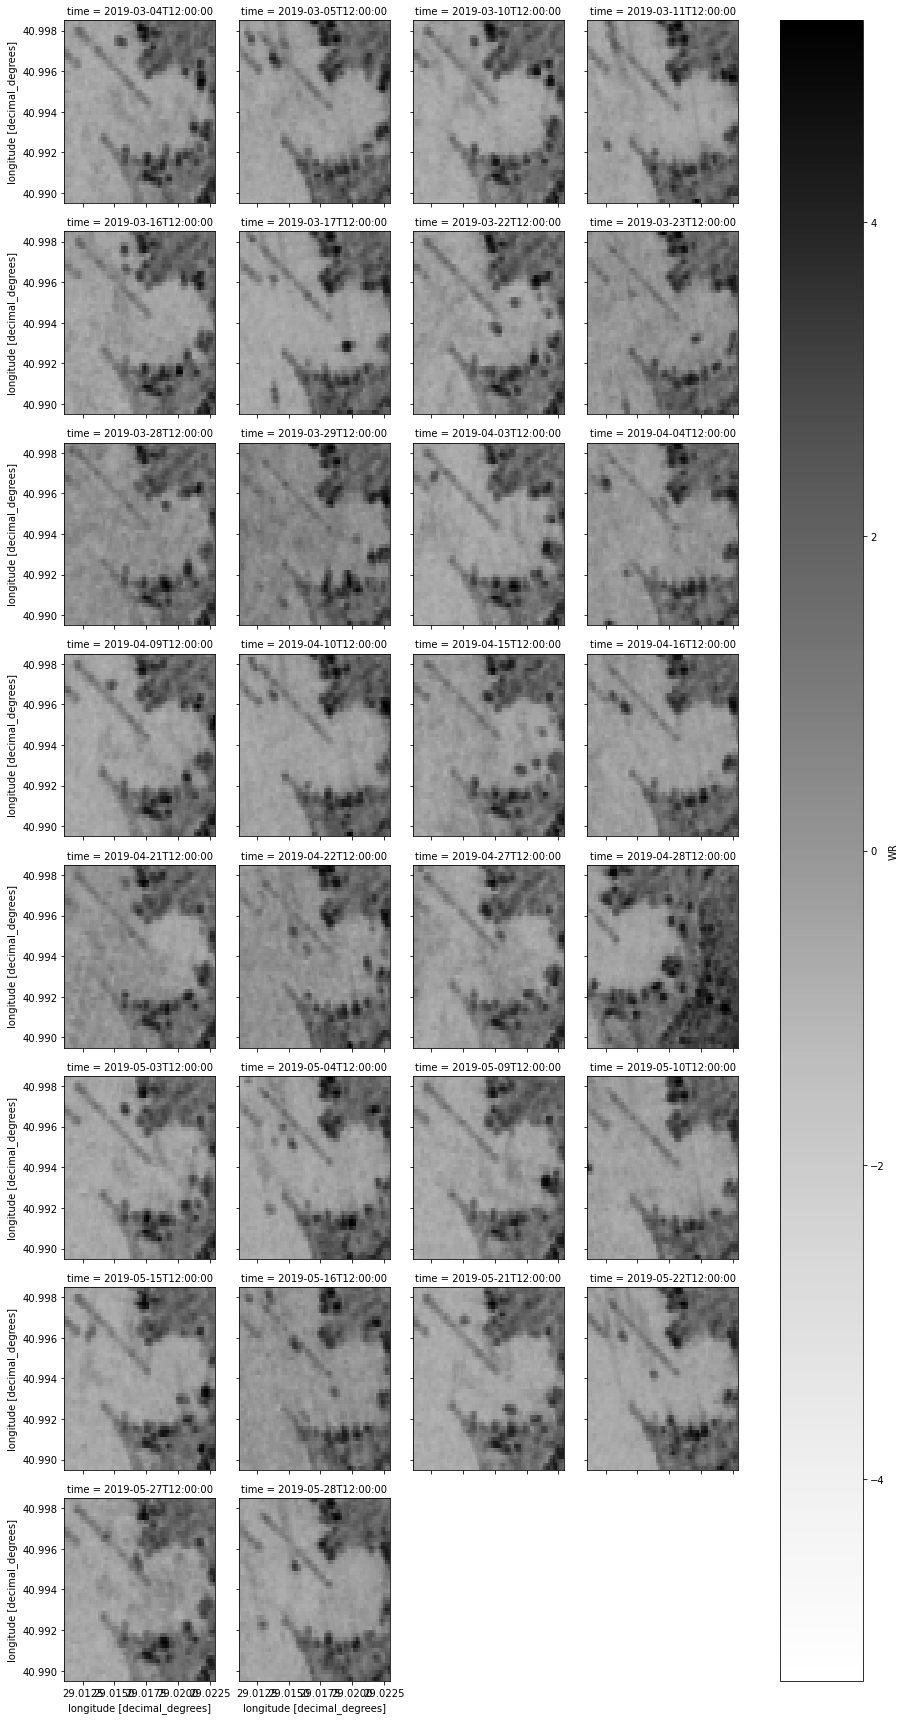

In [209]:
cube["WR"] = - np.log(0.05 / (0.018+cube.VV * 1.5)) # turn to minus compare to the original script
cube["WR"].plot.imshow(col='time', col_wrap=4, cmap='Greys')

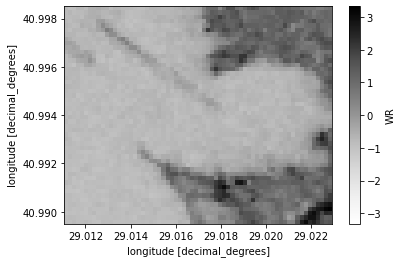

In [214]:
water_roughness_cube_bg, bg_water_roughness = preprocess_sentinel_1(cube, band = "WR", fused_by = "min")
bg_water_roughness.plot.imshow(cmap='Greys')

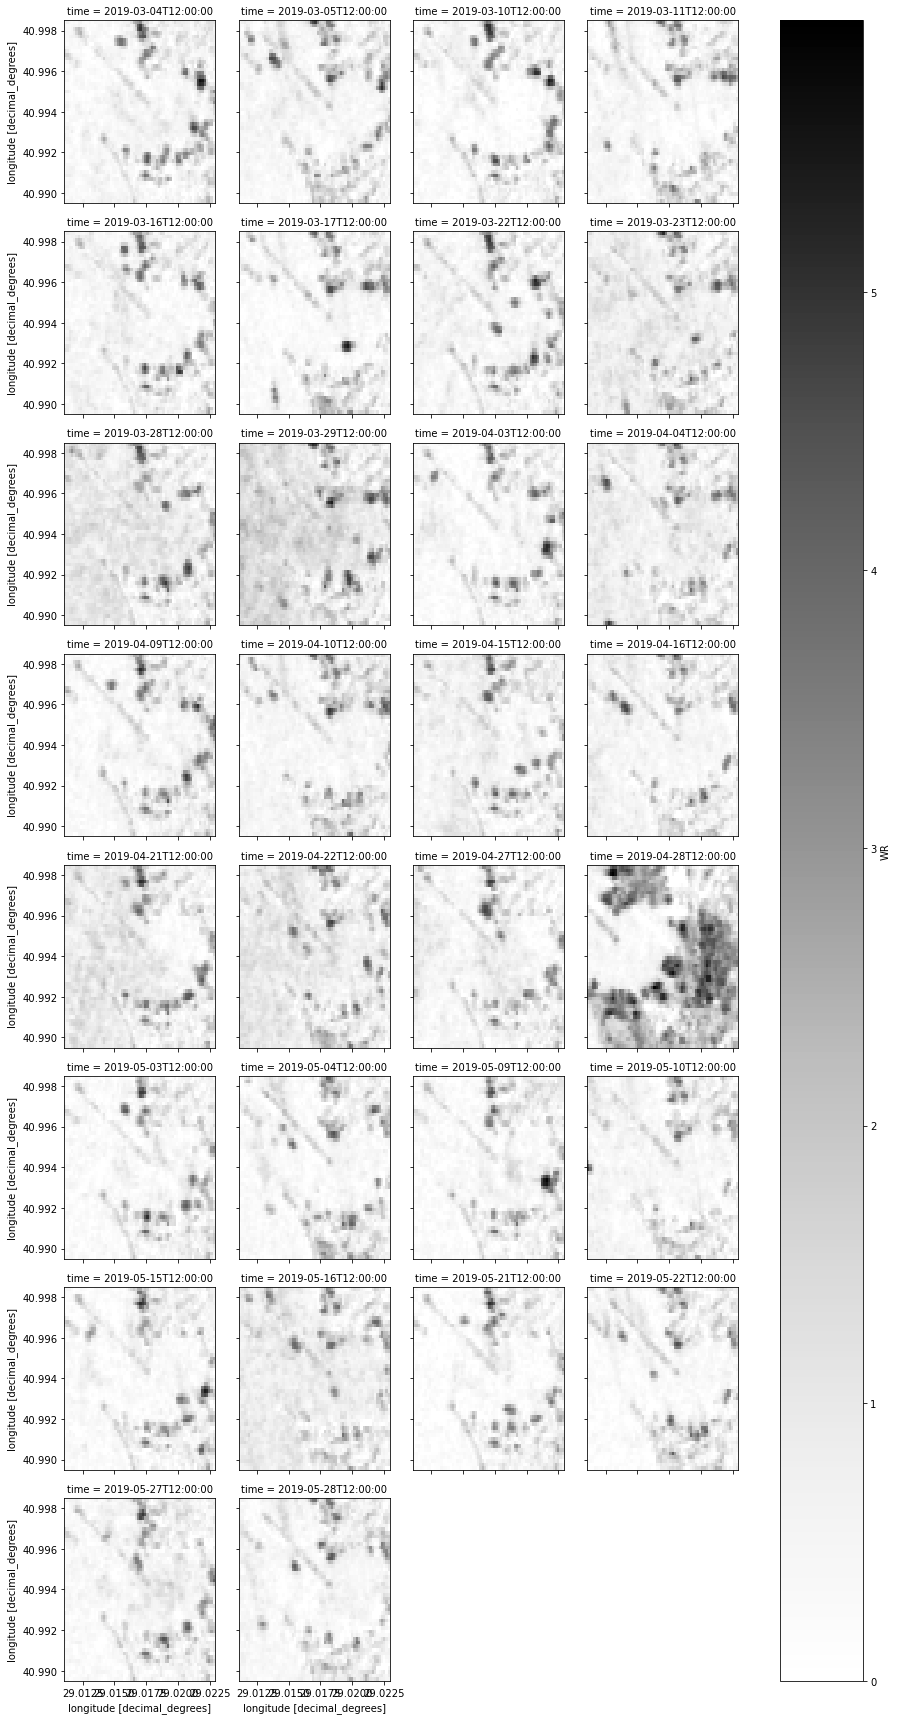

In [215]:
water_roughness_cube_bg.plot.imshow(col='time', col_wrap=4, cmap='Greys')

In [216]:
def overlay(top, bottom):    
    res = ((1 - 2 * top) * bottom + 2 * top) * bottom
    return res


def stretch(arr, min_, max_):
    delta = max_ - min_
    offset = - min_ / delta
    return arr/delta + offset

def gamma(arr, val):
    return arr ** (1.0 / val)

mvh = np.sqrt(cube.VH + 0.002)
mvv = np.sqrt(cube.VV + 0.002)
ov = overlay(mvv, mvh)
red = gamma(stretch(mvh, 0.02, 0.1), 1.1)
green = gamma(stretch(ov, 0.0, 0.06), 1.1)
blue = gamma(stretch(mvv, 0.0, 0.32), 1.1)


[<xarray.DataArray 'VH' (time: 30, lat: 50, lon: 66)>
 dask.array<pow, shape=(30, 50, 66), dtype=float32, chunksize=(1, 50, 66), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 41.0 41.0 41.0 41.0 41.0 ... 40.99 40.99 40.99 40.99
   * lon      (lon) float64 29.01 29.01 29.01 29.01 ... 29.02 29.02 29.02 29.02
   * time     (time) datetime64[ns] 2019-03-04T12:00:00 ... 2019-05-28T12:00:00,
 <xarray.DataArray (time: 30, lat: 50, lon: 66)>
 dask.array<pow, shape=(30, 50, 66), dtype=float32, chunksize=(1, 50, 66), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 41.0 41.0 41.0 41.0 41.0 ... 40.99 40.99 40.99 40.99
   * lon      (lon) float64 29.01 29.01 29.01 29.01 ... 29.02 29.02 29.02 29.02
   * time     (time) datetime64[ns] 2019-03-04T12:00:00 ... 2019-05-28T12:00:00,
 <xarray.DataArray 'VV' (time: 30, lat: 50, lon: 66)>
 dask.array<pow, shape=(30, 50, 66), dtype=float32, chunksize=(1, 50, 66), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (la

In [217]:
cube['R'] = red
cube['G'] = green
cube['B'] = blue


In [122]:
cube_bands = cube.expand_dims("band")
cube_rgb = xarray.concat([cube_bands.R, cube_bands.G, cube_bands.B], dim="band")


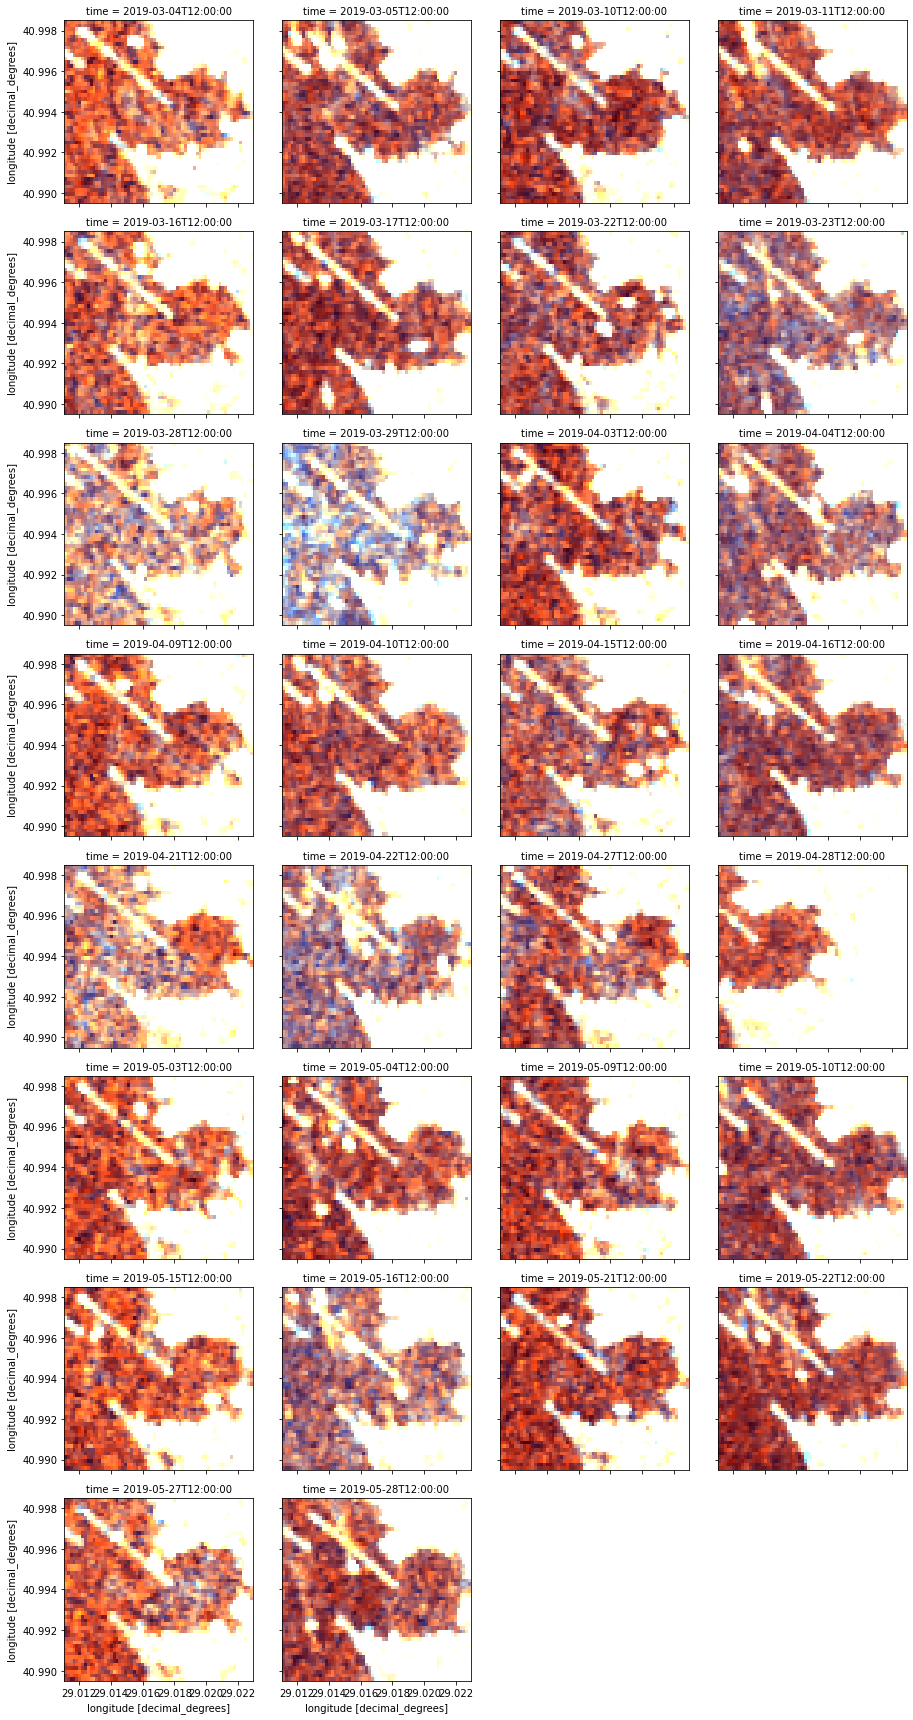

In [138]:
cube_rgb.plot.imshow(col='time', col_wrap=4, vmin=0, vmax=1, cmap='RdYlBu')

In [128]:
cube_bands

<xarray.Dataset>
Dimensions:    (band: 1, bnds: 2, lat: 50, lon: 66, time: 30)
Coordinates:
  * lat        (lat) float64 41.0 41.0 41.0 41.0 ... 40.99 40.99 40.99 40.99
  * lon        (lon) float64 29.01 29.01 29.01 29.01 ... 29.02 29.02 29.02 29.02
  * time       (time) datetime64[ns] 2019-03-04T12:00:00 ... 2019-05-28T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(30, 2), meta=np.ndarray>
Dimensions without coordinates: band, bnds
Data variables:
    HH         (band, time, lat, lon) float32 dask.array<chunksize=(1, 1, 50, 66), meta=np.ndarray>
    HH+HV      (band, time, lat, lon) float32 dask.array<chunksize=(1, 1, 50, 66), meta=np.ndarray>
    VH         (band, time, lat, lon) float32 dask.array<chunksize=(1, 1, 50, 66), meta=np.ndarray>
    VV         (band, time, lat, lon) float32 dask.array<chunksize=(1, 1, 50, 66), meta=np.ndarray>
    VV+VH      (band, time, lat, lon) float32 dask.array<chunksize=(1, 1, 50, 66), meta=np.ndarray>
    R          (band, time, lat, lon) float32 dask.array<chunksize=(1, 1, 50, 66), meta=np.ndarray>
    G          (band, time, lat, lon) float32 dask.array<chunksize=(1, 1, 50, 66), meta=np.ndarray>
    B          (band, time, lat, lon) float32 dask.array<chunksize=(1, 1, 50, 66), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     S1GRD Data Cube Subset
    history:                   [{'program': 'xcube_sh.store.SentinelHubStore'...
    date_created:              2020-06-04T12:57:29.501288
    processing_level:          L1B
    time_coverage_start:       2019-03-01T00:00:00+00:00
    time_coverage_end:         2019-06-02T00:00:00+00:00
    time_coverage_duration:    P93DT0H0M0S
    time_coverage_resolution:  P1DT0H0M0S
    geospatial_lon_min:        29.011059019742685
    geospatial_lat_min:        40.98949867050243
    geospatial_lon_max:        29.022939019742687
    geospatial_lat_max:        40.99849867050243